In [1]:
import xlrd
import xlsxwriter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from sklearn import linear_model

#open excel file
predata = xlrd.open_workbook('PreRegression.xlsx')
table_predata = predata.sheets()[0]

three_factors = xlrd.open_workbook('Europe_3_Factors.xlsx')
table_3_factors = three_factors.sheets()[0]

mom_factors = xlrd.open_workbook('Europe_MOM_Factor.xlsx')
table_mom_factors = mom_factors.sheets()[0]

In [2]:
for i in range(0,table_predata.nrows):
    locals()['predata_'+str(i)] = table_predata.row_values(i)
    
#there are 3276 funds
for i in range(0,3276):
    locals()['predata_FundID_'+str(i+1)] = []
    locals()['predata_FundSize_'+str(i+1)] = []
    locals()['predata_FundFlow_'+str(i+1)] = []
    locals()['predata_FundReturn_'+str(i+1)] = []
    locals()['predata_FundSustainability_'+str(i+1)] = []
    for j in range(0,92):
        locals()['predata_FundID_'+str(i+1)].append(table_predata.row_values(1+j+i*92)[1])
        locals()['predata_FundSize_'+str(i+1)].append(table_predata.row_values(1+j+i*92)[11])
        locals()['predata_FundFlow_'+str(i+1)].append(table_predata.row_values(1+j+i*92)[12])
        locals()['predata_FundReturn_'+str(i+1)].append(table_predata.row_values(1+j+i*92)[13])
        locals()['predata_FundSustainability_'+str(i+1)].append(table_predata.row_values(1+j+i*92)[14])
        
        
#two factors excel will be saved in array        
for i in range(0,table_3_factors.nrows):
    locals()['three_factors_'+str(i)] = table_3_factors.row_values(i)     
    
for i in range(0,table_mom_factors.nrows):
    locals()['mom_factors_'+str(i)] = table_mom_factors.row_values(i)    
    
    
mkt_rf = []
smb = []
hml = []
rf = []
mom = []

for i in range(1,table_3_factors.nrows):
    mkt_rf.append(locals()['three_factors_'+str(i)][1])
    smb.append(locals()['three_factors_'+str(i)][2])
    hml.append(locals()['three_factors_'+str(i)][3])
    rf.append(locals()['three_factors_'+str(i)][4])

for i in range(1,table_mom_factors.nrows):
    mom.append(locals()['mom_factors_'+str(i)][1])

In [3]:
#remove the nan item of each fund and corresponding mkt-rf
def remove_nan(x, y):
    
    nan = []

    for i in range(len(y)):
        if y[i] == 0:
            nan.append(i)

    f_it = [v for i, v in enumerate(x) if i not in nan]
    r_it = [v for i, v in enumerate(y) if i not in nan]
    
    return f_it, r_it

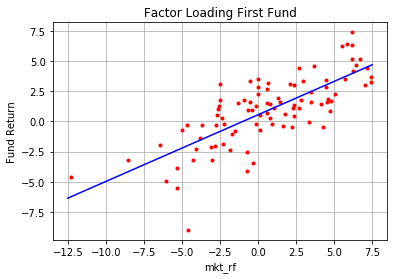

/home/yuxuan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/yuxuan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/yuxuan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/yuxuan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/yuxuan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/yuxuan/anaconda3/lib/python3.7/site-packages/IPyt

In [4]:
beta_value = []

#example for how to do the regression on beta

f_it, r_it = remove_nan(mkt_rf, predata_FundReturn_1)
     
polynom1 = np.polyfit(f_it, r_it, 1)
x1 = np.linspace(-12.5, 7.5, 92)
y1 = [polynom1[0]*ix + polynom1[1] for ix in x1]
plt.cla()
plt.plot(f_it, r_it, ".r")
plt.plot(x1, y1, "-b")
plt.grid(True)
plt.title("Factor Loading First Fund")
plt.xlabel("mkt_rf")
plt.ylabel("Fund Return")
plt.pause(.5)

#Totoally 3276 beta value in the array
for i in range(1,3277):
    f_it, r_it = remove_nan(mkt_rf, locals()['predata_FundReturn_'+str(i)])
    regression_1 = np.polyfit(f_it, r_it, 1)
    beta_value.append(regression_1[0])

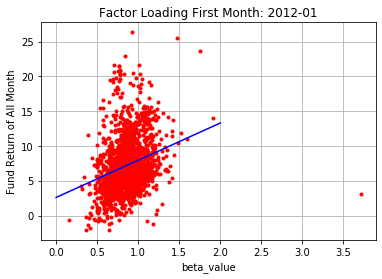

In [5]:
#split the table: totally 92 arrays, which include all Fund values in every single month
lambda_value = []

for i in range(0,92):
    locals()['return_AMFund_'+str(i+1)] = []
    
for x in range(0,92):
    for y in range(0,3276):
        locals()['return_AMFund_'+str(x+1)].append(locals()['predata_FundReturn_'+str(y+1)][x])

#example for how to do the regression on lambda
f_it, r_it = remove_nan(beta_value, return_AMFund_1)

polynom2 = np.polyfit(f_it, r_it, 1)
x2 = np.linspace(0, 2, 3276)
y2 = [polynom2[0]*ix + polynom2[1] for ix in x2]
plt.cla()
plt.plot(f_it, r_it, ".r")
plt.plot(x2, y2, "-b")
plt.grid(True)
plt.title("Factor Loading First Month: 2012-01")
plt.xlabel("beta_value")
plt.ylabel("Fund Return of All Month")
plt.pause(.5)


#Totoally 92 months to caculate the lambda

for i in range(0,92):
    f_it, r_it = remove_nan(beta_value, locals()['return_AMFund_'+str(i+1)])
    regression_2 = np.polyfit(f_it, r_it, 1)
    lambda_value.append(regression_2[0])

In [6]:
#calculate the performace by (return - rf- lambda*beta)        
for i in range(0,3276):
    locals()['performance_'+str(i+1)] = []
    for j in range(0,92):
        locals()['performance_'+str(i+1)].append(locals()['predata_FundReturn_'+str(i+1)][j]-rf[j]-beta_value[i]*lambda_value[j])

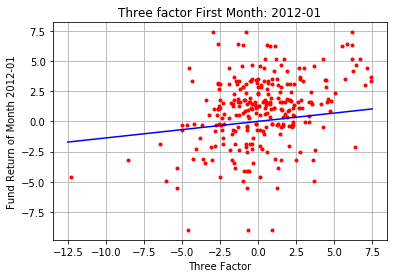

In [7]:
#multiple variable regression on beta
three_factor = []
beta_value_three_factor = []

for i in range(0,92):
    three_son = []
    three_son.append(mkt_rf[i])
    three_son.append(smb[i])
    three_son.append(hml[i])
    three_factor.append(three_son)

#example for how to do the multivariate regression on beta

f_it, r_it = remove_nan(three_factor, predata_FundReturn_1)

reg = linear_model.LinearRegression()
reg.fit(f_it, r_it)
polynom3 = reg.coef_

x3 = np.linspace(-12.5, 7.5, 92)
y3 = [polynom3[0]*ix + polynom3[1]*ix + polynom3[2]*ix for ix in x3]
plt.cla()
plt.plot(mkt_rf, predata_FundReturn_1, ".r")
plt.plot(smb, predata_FundReturn_1, ".r")
plt.plot(hml, predata_FundReturn_1, ".r")
plt.plot(x3, y3, "-b")
plt.grid(True)
plt.title("Three factor First Month: 2012-01")
plt.xlabel("Three Factor")
plt.ylabel("Fund Return of Month 2012-01")
plt.pause(.5)


#Totoally 3276 beta value in the array
for i in range(1,3277):
    reg = linear_model.LinearRegression()
    f_it, r_it = remove_nan(three_factor, locals()['predata_FundReturn_'+str(i)])
    reg.fit(f_it, r_it)
    regression_3 = reg.coef_
    beta_value_three_factor.append(regression_3)


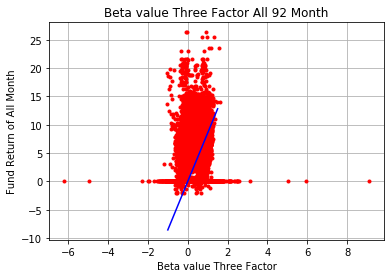

In [8]:
#multiple variable regression on lambda
lambda_value_three_factor = []

#example for how to do the multivariate regression on lambda
reg = linear_model.LinearRegression()
f_it, r_it = remove_nan(beta_value_three_factor, return_AMFund_1)
reg.fit(f_it, r_it)
polynom4 = reg.coef_

x4 = np.linspace(-1.0, 1.5, 3276)
y4 = [polynom4[0]*ix + polynom4[1]*ix + polynom4[2]*ix for ix in x4]
plt.cla()
for i in range(0,3276):
    plt.plot(beta_value_three_factor[i][0], return_AMFund_1[i], ".r")
    plt.plot(beta_value_three_factor[i][1], return_AMFund_1[i], ".r")
    plt.plot(beta_value_three_factor[i][2], return_AMFund_1[i], ".r")
plt.plot(x4, y4, "-b")
plt.grid(True)
plt.title("Beta value Three Factor All 92 Month")
plt.xlabel("Beta value Three Factor")
plt.ylabel("Fund Return of All Month")
plt.pause(.5)


#Totoally 92 months to caculate the lambda
for i in range(0,92):
    reg = linear_model.LinearRegression()
    f_it, r_it = remove_nan(beta_value_three_factor, locals()['return_AMFund_'+str(i+1)])
    reg.fit(f_it, r_it)
    regression_4 = reg.coef_
    lambda_value_three_factor.append(regression_4)


In [9]:
#calculate the performace by (return - rf- lambda*beta) using three factors       
for i in range(0,3276):
    locals()['performance_three_factor'+str(i+1)] = []
    for j in range(0,92):
        locals()['performance_three_factor'+str(i+1)].append(locals()['predata_FundReturn_'+str(i+1)][j] - rf[j] - beta_value_three_factor[i][0]*lambda_value_three_factor[j][0] - beta_value_three_factor[i][1]*lambda_value_three_factor[j][1] - beta_value_three_factor[i][2]*lambda_value_three_factor[j][2])

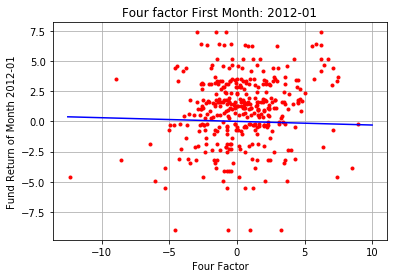

In [10]:
#multiple variable regression on beta, mom inkulsiv
four_factor = []
beta_value_four_factor = []

for i in range(0,92):
    four_son = []
    four_son.append(mkt_rf[i])
    four_son.append(smb[i])
    four_son.append(hml[i])
    four_son.append(mom[i])
    four_factor.append(four_son)

#example for how to do the multivariate regression on beta

f_it, r_it = remove_nan(four_factor, predata_FundReturn_1)

reg = linear_model.LinearRegression()
reg.fit(f_it, r_it)
polynom5 = reg.coef_

x5 = np.linspace(-12.5, 10, 92)
y5 = [polynom5[0]*ix + polynom5[1]*ix + polynom5[2]*ix + polynom5[3]*ix for ix in x5]
plt.cla()
plt.plot(mkt_rf, predata_FundReturn_1, ".r")
plt.plot(smb, predata_FundReturn_1, ".r")
plt.plot(hml, predata_FundReturn_1, ".r")
plt.plot(mom, predata_FundReturn_1, ".r")
plt.plot(x5, y5, "-b")
plt.grid(True)
plt.title("Four factor First Month: 2012-01")
plt.xlabel("Four Factor")
plt.ylabel("Fund Return of Month 2012-01")
plt.pause(.5)


#Totoally 3276 beta value in the array
for i in range(1,3277):
    f_it, r_it = remove_nan(four_factor, locals()['predata_FundReturn_'+str(i)])
    reg = linear_model.LinearRegression()
    reg.fit(f_it, r_it)
    regression_5 = reg.coef_
    beta_value_four_factor.append(regression_5)

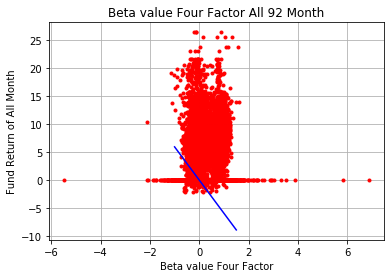

In [11]:
#multiple variable regression on lambda, mom inkulsiv
lambda_value_four_factor = []

#example for how to do the multivariate regression on lambda

f_it, r_it = remove_nan(beta_value_four_factor, return_AMFund_1)
reg = linear_model.LinearRegression()
reg.fit(f_it, r_it)
polynom6 = reg.coef_

x6 = np.linspace(-1.0, 1.5, 3276)
y6 = [polynom6[0]*ix + polynom6[1]*ix + polynom6[2]*ix + polynom6[3]*ix for ix in x6]
plt.cla()
for i in range(0,3276):
    plt.plot(beta_value_four_factor[i][0], return_AMFund_1[i], ".r")
    plt.plot(beta_value_four_factor[i][1], return_AMFund_1[i], ".r")
    plt.plot(beta_value_four_factor[i][2], return_AMFund_1[i], ".r")
    plt.plot(beta_value_four_factor[i][3], return_AMFund_1[i], ".r")
plt.plot(x6, y6, "-b")
plt.grid(True)
plt.title("Beta value Four Factor All 92 Month")
plt.xlabel("Beta value Four Factor")
plt.ylabel("Fund Return of All Month")
plt.pause(.5)

#Totoally 92 months to caculate the lambda
for i in range(0,92):
    f_it, r_it = remove_nan(beta_value_four_factor, locals()['return_AMFund_'+str(i+1)])
    reg = linear_model.LinearRegression()
    reg.fit(f_it, r_it)
    regression_6 = reg.coef_
    lambda_value_four_factor.append(regression_6)

In [12]:
#calculate the performace by (return - rf- lambda*beta) using four factors       
for i in range(0,3276):
    locals()['performance_four_factor'+str(i+1)] = []
    for j in range(0,92):
        locals()['performance_four_factor'+str(i+1)].append(locals()['predata_FundReturn_'+str(i+1)][j] - rf[j] - beta_value_four_factor[i][0]*lambda_value_four_factor[j][0] - beta_value_four_factor[i][1]*lambda_value_four_factor[j][1] - beta_value_four_factor[i][2]*lambda_value_four_factor[j][2] - beta_value_four_factor[i][3]*lambda_value_four_factor[j][3])

In [13]:
#find all fund and month which return is 0, the corresponding performance should be NaN
for i in range(0,3276):
    for j in range(0,92):
        if locals()['predata_FundReturn_'+str(i+1)][j] == 0:
            locals()['performance_'+str(i+1)][j] = "NaN"
            locals()['performance_three_factor'+str(i+1)][j] = "NaN"
            locals()['performance_four_factor'+str(i+1)][j] = "NaN"

In [14]:
wb = load_workbook('PreRegression.xlsx')
ws = wb.active

#write beta value into the file
ws.cell(1, 17, "Beta Value")

for i in range(0,3276):
    for j in range(0,92):
        ws.cell(i*92+j+2, 17, beta_value[i])
        
#write lambda value into the file      
ws.cell(1, 18, "Lambda Value")

for i in range(0,3276):
    for j in range(0,92):
        ws.cell(i*92+j+2, 18, lambda_value[j])
        
#write lambda times beta value into the file      
ws.cell(1, 19, "L*B Value")

for i in range(0,3276):
    for j in range(0,92):
        ws.cell(i*92+j+2, 19, beta_value[i]*lambda_value[j])
        
#write performance value into the file
ws.cell(1, 20, "CAPM Performance")

for i in range(0,3276):
    for j in range(0,92):
        ws.cell(i*92+j+2, 20, locals()['performance_'+str(i+1)][j])
        
#write three factor beta value into the file
ws.cell(1, 22, "Beta Value mkt_rf")
ws.cell(1, 23, "Beta Value smb")
ws.cell(1, 24, "Beta Value hml")

for i in range(0,3276):
    for j in range(0,92):
        ws.cell(i*92+j+2, 22, beta_value_three_factor[i][0])
        ws.cell(i*92+j+2, 23, beta_value_three_factor[i][1])
        ws.cell(i*92+j+2, 24, beta_value_three_factor[i][2])

#write three factor lambda value into the file
ws.cell(1, 25, "Lambda Value mkt_rf")
ws.cell(1, 26, "Lambda Value smb")
ws.cell(1, 27, "Lambda Value hml")

for i in range(0,3276):
    for j in range(0,92):
        ws.cell(i*92+j+2, 25, lambda_value_three_factor[j][0])
        ws.cell(i*92+j+2, 26, lambda_value_three_factor[j][1])
        ws.cell(i*92+j+2, 27, lambda_value_three_factor[j][2])
        
#write lambda times beta value into the file      
ws.cell(1, 28, "L*B Value three factor")

for i in range(0,3276):
    for j in range(0,92):
        ws.cell(i*92+j+2, 28, beta_value_three_factor[i][0]*lambda_value_three_factor[j][0]+beta_value_three_factor[i][1]*lambda_value_three_factor[j][1]+beta_value_three_factor[i][2]*lambda_value_three_factor[j][2])
        
#write performance value into the file
ws.cell(1, 29, "CAPM Performance Three Factor")

for i in range(0,3276):
    for j in range(0,92):
        ws.cell(i*92+j+2, 29, locals()['performance_three_factor'+str(i+1)][j])
        
#write four factor beta value into the file
ws.cell(1, 31, "Beta Value mkt_rf")
ws.cell(1, 32, "Beta Value smb")
ws.cell(1, 33, "Beta Value hml")
ws.cell(1, 34, "Beta Value mom")

for i in range(0,3276):
    for j in range(0,92):
        ws.cell(i*92+j+2, 31, beta_value_four_factor[i][0])
        ws.cell(i*92+j+2, 32, beta_value_four_factor[i][1])
        ws.cell(i*92+j+2, 33, beta_value_four_factor[i][2])
        ws.cell(i*92+j+2, 34, beta_value_four_factor[i][3])

#write four factor lambda value into the file
ws.cell(1, 35, "Lambda Value mkt_rf")
ws.cell(1, 36, "Lambda Value smb")
ws.cell(1, 37, "Lambda Value hml")
ws.cell(1, 38, "Lambda Value mom")

for i in range(0,3276):
    for j in range(0,92):
        ws.cell(i*92+j+2, 35, lambda_value_four_factor[j][0])
        ws.cell(i*92+j+2, 36, lambda_value_four_factor[j][1])
        ws.cell(i*92+j+2, 37, lambda_value_four_factor[j][2])
        ws.cell(i*92+j+2, 38, lambda_value_four_factor[j][3])
        
#write lambda times beta value into the file      
ws.cell(1, 39, "L*B Value four factor")

for i in range(0,3276):
    for j in range(0,92):
        ws.cell(i*92+j+2, 39, beta_value_four_factor[i][0]*lambda_value_four_factor[j][0]+beta_value_four_factor[i][1]*lambda_value_four_factor[j][1]+beta_value_four_factor[i][2]*lambda_value_four_factor[j][2]+beta_value_four_factor[i][3]*lambda_value_four_factor[j][3])
        
#write performance value into the file
ws.cell(1, 40, "CAPM Performance Four Factor")

for i in range(0,3276):
    for j in range(0,92):
        ws.cell(i*92+j+2, 40, locals()['performance_four_factor'+str(i+1)][j])
        
wb.save('AfterRegression.xlsx')